# Data exploration and visualization

In [2]:
from src.data.dataset import * 
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import cv2
import fiftyone.brain as fob
import json
import matplotlib.pyplot as plt
from PIL import Image

 100% |█████████████████| 360/360 [266.7ms elapsed, 0s remaining, 1.3K samples/s]      
 100% |█████████████████| 101/101 [93.5ms elapsed, 0s remaining, 1.1K samples/s]   
 100% |███████████████████| 51/51 [59.4ms elapsed, 0s remaining, 858.2 samples/s]  


## Load dataset (COCO format)

Note that we are merging different splits of the dataset (train, val, test) into a single dataset.

In [ ]:
datasets = []
for split in ['train', 'valid', 'test']:
    dataset_root = Path(f'data/{split}')
    annotation_fp = dataset_root / '_annotations.coco.json'
    dataset = get_dataset(dataset_root, annotation_fp)
    datasets.append(dataset)
combined_dataset = merge_datasets(datasets)

### Parse classification labels from json files

In [54]:
def parse_user_tags(json_fp: Path) -> dict:
    # Read the JSON file
    with open(json_fp, 'r') as f:
        data = json.load(f)

    # Initialize a dictionary to store image IDs and corresponding user_tags
    image_user_tags_dict = {}

    # Iterate over the images
    for image in data['images']:
        image_id = image['file_name'].split('.')[2]
        user_tags = image.get('extra', {}).get('user_tags', [])
        image_user_tags_dict[image_id] = user_tags

    return image_user_tags_dict

train_tags = parse_user_tags(Path('data/train/_annotations.coco.json'))
valid_tags = parse_user_tags(Path('data/valid/_annotations.coco.json'))
test_tags = parse_user_tags(Path('data/test/_annotations.coco.json'))

# combine the tags
combined_tags = {**train_tags, **valid_tags, **test_tags}

### Add the parsed labels to the dataset

In [55]:
# add classification labels to the datasets
error_count = 0
combined_dataset_with_tags = combined_dataset.clone()
for sample in combined_dataset_with_tags:
    unique_id = Path(sample.filepath).stem.split('.')[2]
    try:
        sample["ground_truth"] = fo.Classification(label=combined_tags[unique_id][0])
        sample.save()
    except KeyError:
        error_count += 1
        pass

print(f"Failed to add tags to {error_count} samples")

Failed to add tags to 0 samples


## Feature visualizations

### t-SNE visualization of the features

In [82]:
embeddings = np.array([
    cv2.imread(f, cv2.IMREAD_UNCHANGED).ravel()
    for f in combined_dataset_with_tags.values("filepath")
])

results = fob.compute_visualization(
    combined_dataset,
    embeddings=embeddings,
    num_dims=2,
    method="tsne",
    brain_key="umap_viz",
    verbose=True,
    seed=51,
)

Generating visualization...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 512 samples in 0.003s...
[t-SNE] Computed neighbors for 512 samples in 0.201s...
[t-SNE] Computed conditional probabilities for sample 512 / 512
[t-SNE] Mean sigma: 3569.018669
[t-SNE] Computed conditional probabilities in 0.020s
[t-SNE] Iteration 50: error = 54.7612915, gradient norm = 0.2163504 (50 iterations in 0.078s)
[t-SNE] Iteration 100: error = 53.3307114, gradient norm = 0.2167045 (50 iterations in 0.074s)
[t-SNE] Iteration 150: error = 52.3008118, gradient norm = 0.2078873 (50 iterations in 0.072s)
[t-SNE] Iteration 200: error = 53.0446587, gradient norm = 0.2269059 (50 iterations in 0.074s)
[t-SNE] Iteration 250: error = 51.5885735, gradient norm = 0.2299395 (50 iterations in 0.068s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.588573
[t-SNE] Iteration 300: error = 0.3167780, gradient norm = 0.0035326 (50 iterations in 0.068s)
[t-SNE] Iteration 350: error = 0.25537

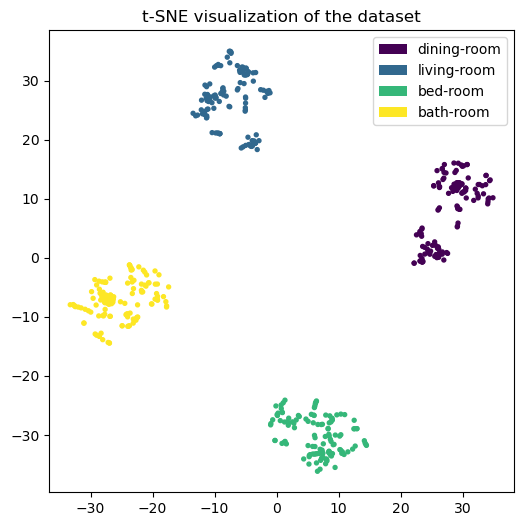

In [183]:
# extract the ground truth labels
labels = combined_dataset_with_tags.values("ground_truth.label")

# create color map for visualization
label_to_id_map = {label: i for i, label in enumerate(set(labels))}
label_ids = [label_to_id_map[label] for label in labels]

# sample colors from the tab10 colormap
colormap = plt.cm.viridis(np.linspace(0, 1, len(set(labels))))

# assign colors to every point
pt_colors = [colormap[label_id] for label_id in label_ids]

plt.figure(figsize=(6, 6))
plt.title("t-SNE visualization of the dataset")
plt.scatter(results.points[:, 0], results.points[:, 1], c=pt_colors, s=8)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10) for c in colormap]
handles = [plt.bar([0], [0], color=c) for c in colormap]
plt.legend(handles, label_to_id_map.keys(), loc='upper right')
plt.show()

## Sample images

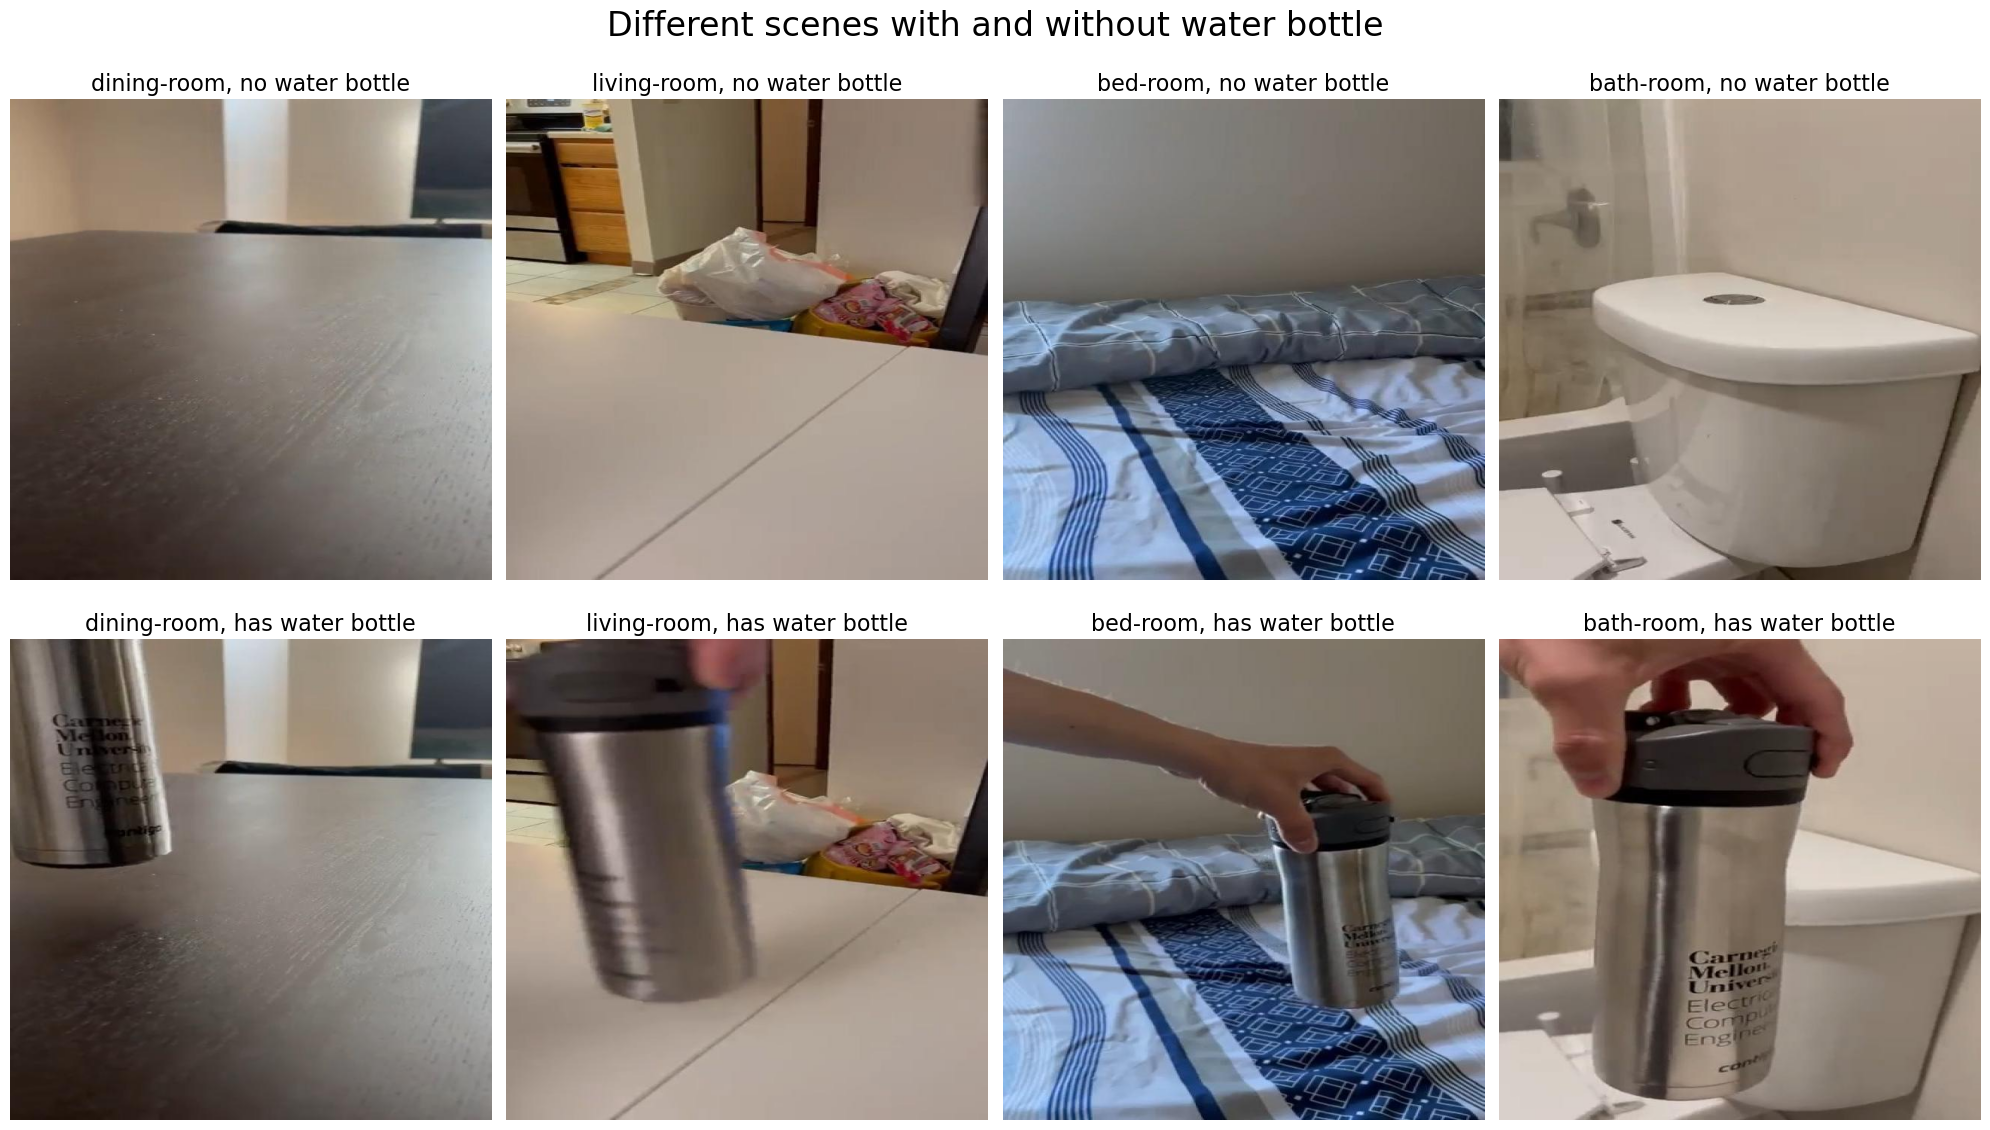

In [241]:
ds_w_bottle = combined_dataset_with_tags.match({'detections': {'$exists': True}})
ds_wo_bottle = combined_dataset_with_tags.match({'detections': {'$exists': False}})

fig, ax = plt.subplots(2, 4, figsize=(20, 12), tight_layout=True)
fig.suptitle("Different scenes with and without water bottle", fontsize=24)
classes = set(ds_w_bottle.values("ground_truth.label"))
for i, ds in enumerate([ds_wo_bottle, ds_w_bottle]):
    for j, class_name in enumerate(classes):
        class_sample = ds.match({'ground_truth.label': class_name}).take(1)
        fp = class_sample.values("filepath")[0]
        img = Image.open(fp)
        ax[i, j].imshow(img)
        ax[i, j].set_title(f"{class_name}, {'has' if i else 'no'} water bottle", fontsize=16)
        ax[i, j].axis('off')

plt.show()